In [1]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 200)

%matplotlib inline

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor,AdaBoostRegressor, ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression, logistic
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import pickle

In [3]:
def rmv_extv(df, column,down=.1,up=.95):
    ext_95=df[(df[column]<=df[column].quantile(up))].reset_index(drop=True)
    return ext_95[(ext_95[column]>=ext_95[column].quantile(down))].reset_index(drop=True)

In [4]:
df=pd.read_csv("Starbucks_Cluster_600_rempl.csv", index_col="Unnamed: 0")
#df=rmv_extv(df,"Total personas", down=.1).copy()
df.shape

(617, 11)

In [5]:
df["Total personas"].value_counts()

1     436
2     136
3      27
4       9
5       5
10      2
6       2
Name: Total personas, dtype: int64

In [6]:
martes1=df.iloc[:77].reset_index(drop=True)

miercoles1=df.iloc[77:129].reset_index(drop=True)

jueves1=df.iloc[129:160].reset_index(drop=True)

viernes1=df.iloc[160:209].reset_index(drop=True)

sabado1=df.iloc[209:270].reset_index(drop=True)

domingo1=df.iloc[270:320].reset_index(drop=True)

martes2=df.iloc[320:410].reset_index(drop=True)

miercoles2=df.iloc[410:493].reset_index(drop=True)

jueves2=df.iloc[493:542].reset_index(drop=True)

viernes2=df.iloc[542:].reset_index(drop=True)

In [7]:

def creat(data,start,end, join=False):
    if join==False:
        aux=pd.DataFrame([], columns=["X(%d)" %-x for x in np.arange(-start+1,0)]+["Ancla"]+["y(%s)" %x 
                                               for x in np.arange(1,end+1)])
        a=data[["Total personas"]].T.copy()


        for j in range(a.shape[1]-start-end+1):
            va=a.iloc[:,j:start+end+j]
            va.columns=["X(%d)" %-x for x in np.arange(-start+1,0)]+["Ancla"]+["y(%s)" %x for x in np.arange(1,end+1)]

            aux=pd.concat([aux,va])

        return aux.reset_index(drop=True)

    else:
        
        aux2=pd.DataFrame([], columns=["X(%d)" %-x 
                                       for x in np.arange(-start+1,0)]+["Ancla"]+["y(%s)" %x 
                                       for x in np.arange(1,end+1)])
        for d in data:
        
            aux2=pd.concat([aux2,creat(d, start,end)])
        
        return aux2.reset_index(drop=True)


In [8]:
def ninc(x):
    return sum([int(a<b) for a,b in zip(x,x[1:])])

In [9]:
def delta(x):
    return np.mean([(b-a) for a,b in zip(x,x[1:])])

In [10]:
df=creat([martes1,martes2]
      , 10,5, join=True)

for j in range(0,10,2):
    for k in ["mean", "sum", "max", "min", "std", ninc, ]:
        if type(k)==str:
            nombre=k
        else:nombre=k.func_name
        
        
        if j==0:
            df["v_%s_%s" %(nombre, 10-j)]=df.loc[:,"X(%d)"%(9):"Ancla"].apply(k,axis=1)
        
        else: df["v_%s_%s" %(nombre, 10-j)]=df.loc[:,"X(%d)"%(10-j):"Ancla"].apply(k,axis=1)

In [11]:
Y=[x for x in df.columns if "y" in x]

df[Y]=df[Y].replace(range(3,10), "3 o más")

In [12]:
df["target"]=df[Y].sum(axis=1)
df=df[df["target"]<9].copy()

lbl_1=LabelEncoder()
lbl_1.fit(df["y(1)"])
for i in Y:
    df[i]=lbl_1.transform(df[i])

In [13]:
X=df[list(set(df.columns)-(set(Y)|{"target"}))]
y=df["target"].copy()

In [14]:
y.value_counts()

6.0    44
7.0    38
5.0    30
8.0    16
Name: target, dtype: int64

In [15]:
scx=MinMaxScaler()
scy=MinMaxScaler()
scx.fit(X)
scy.fit(y)
Xm=pd.DataFrame(scx.transform(X), columns=X.columns)
ym=pd.Series(scy.transform(y))


/home/comdisde/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/comdisde/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [33]:
df.shape

(128, 46)

In [45]:
mdsx=MDS(n_components=46)
mdsx.fit(Xm)

Xmm=pd.DataFrame(mdsx.fit_transform(Xm), columns=["d%d" %x for x in range(46)])


In [47]:
Xt,Xv,yt,yv = train_test_split(Xmm,ym,train_size=0.7)

# ML

In [49]:
model = XGBRegressor()
model.fit(Xt,yt)

print r2_score(y_pred=model.predict(Xt),y_true=yt)
print r2_score(y_pred=model.predict(Xv),y_true=yv)
print mean_absolute_error(y_pred=model.predict(Xt),y_true=yt)
print mean_absolute_error(y_pred=model.predict(Xv),y_true=yv)
"""print accuracy_score(y_pred=model.predict(Xt),y_true=yt)
print accuracy_score(y_pred=model.predict(Xv),y_true=yv)
print f1_score(average="weighted",y_pred=model.predict(Xt),y_true=yt)
print f1_score(average="weighted",y_pred=model.predict(Xv),y_true=yv)"""



0.989564615507
0.213177484863
0.0253118604756
0.207655483077


'print accuracy_score(y_pred=model.predict(Xt),y_true=yt)\nprint accuracy_score(y_pred=model.predict(Xv),y_true=yv)\nprint f1_score(average="weighted",y_pred=model.predict(Xt),y_true=yt)\nprint f1_score(average="weighted",y_pred=model.predict(Xv),y_true=yv)'

## Classifier

In [50]:
param_grid_SVC=dict(C=np.arange(.5,2,.1),kernel=["rbf", "linear", "poly", "sigmoid"], degree=range(1,10),
                   coef0=np.arange(.001,.011,.001), decision_function_shape=['ovo', 'ovr',None], 
                    probability=[True])
param_grid_KN=dict(n_neighbors=range(1,66), weights=['uniform', 'distance',], 
              algorithm=['auto'], leaf_size=[30], p=[2], metric=['minkowski'], 
                   metric_params=[None],)

param_grid_XGBC=dict(max_depth=range(15,30,3), n_estimators=range(2000,10000,1000), 
                learning_rate=np.arange(.001,.011,.001), booster=["gbtree", "gblinear", "dart"],
                    base_score=np.arange(.1,1.1,.1),
                   )

## Regressor

In [51]:
param_grid_RF=dict(n_estimators=range(1000,10000,100), criterion=["mse",  "mae"],
                  bootstrap=[True],  min_samples_split=range(200,500,100), 
                   min_samples_leaf=range(1000,5000,500),max_features=["auto", "sqrt", "log2"]
                   )
param_grid_SVR=dict(C=np.arange(.5,2,.1),kernel=["rbf", "linear", "poly", "sigmoid"], degree=range(1,10),
                   coef0=np.arange(.001,.011,.001), decision_function_shape=['ovo', 'ovr',None], 
                    probability=[True])
param_grid_XGB=dict(n_estimators=range(60000,70000,1000), 
                learning_rate=np.arange(.004,.005,.0001), booster=["gbtree",],
                    base_score=[.54]
                   , max_depth=range(60000,70000,1000),  colsample_bytree=np.arange(.3,.4,.01),
                    objective=["reg:logistic", ],silent=[True], 
                   max_delta_step=range(10000,20000,1000), subsample=np.arange(.2,.3,.01),
                    
                     )



In [53]:
grid= RandomizedSearchCV(model,scoring="r2", verbose=True
                     , param_distributions=param_grid_XGB, cv=6, n_jobs=-1, n_iter=20)
grid.fit(Xt,yt)


Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.4min finished


RandomizedSearchCV(cv=6, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'colsample_bytree': array([ 0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,
        0.39,  0.4 ]), 'silent': [True], 'learning_rate': array([ 0.004 ,  0.0041,  0.0042,  0.0043,  0.0044,  0.0045,  0.0046,
        0.0047,  0.0048,  0.0049]), 'max_delta_step': [10000,...pth': [60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000], 'booster': ['gbtree']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          ret

In [54]:
print grid.best_params_
print grid.best_estimator_
print grid.score(X=Xt,y=yt)
print grid.score(X=Xv,y=yv)

{'colsample_bytree': 0.29999999999999999, 'silent': True, 'learning_rate': 0.0041000000000000003, 'max_delta_step': 11000, 'base_score': 0.54, 'n_estimators': 68000, 'subsample': 0.20000000000000001, 'objective': 'reg:logistic', 'max_depth': 66000, 'booster': 'gbtree'}
XGBRegressor(base_score=0.54, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.29999999999999999, gamma=0,
       learning_rate=0.0041000000000000003, max_delta_step=11000,
       max_depth=66000, min_child_weight=1, missing=None,
       n_estimators=68000, n_jobs=1, nthread=None,
       objective='reg:logistic', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.20000000000000001)
0.990037194254
-0.200033472368


model=grid.best_estimator_
print accuracy_score(y_pred=model.predict(Xt),y_true=yt)
print accuracy_score(y_pred=model.predict(Xv),y_true=yv)
print f1_score(average="weighted",y_pred=model.predict(Xt),y_true=yt)
print f1_score(average="weighted",y_pred=model.predict(Xv),y_true=yv)



In [22]:
model=grid.best_estimator_
print r2_score(y_pred=model.predict(Xt),y_true=yt)
print r2_score(y_pred=model.predict(Xv),y_true=yv)
print mean_absolute_error(y_pred=model.predict(Xt),y_true=yt)
print mean_absolute_error(y_pred=model.predict(Xv),y_true=yv)


0.801196116531
0.268894641636
0.109251373039
0.185239610931


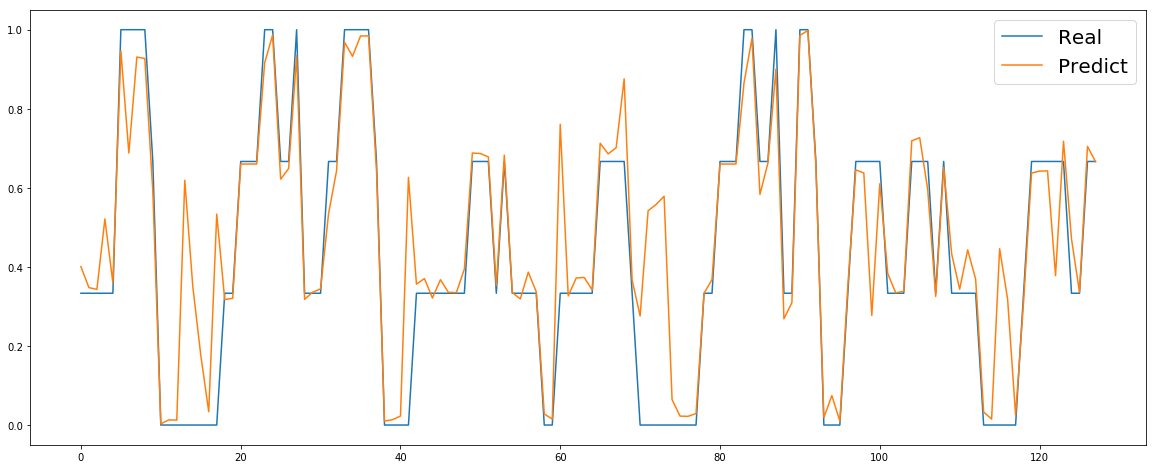

In [56]:

fig, ax = plt.subplots(figsize=(20, 8))


fig=ym.astype(float).reset_index(drop=True).plot(ax=ax,label="Real")
pd.Series(model.predict(Xmm)).plot(ax=ax, label="Predict")
plt.legend(fontsize=20)

/home/comdisde/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/comdisde/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


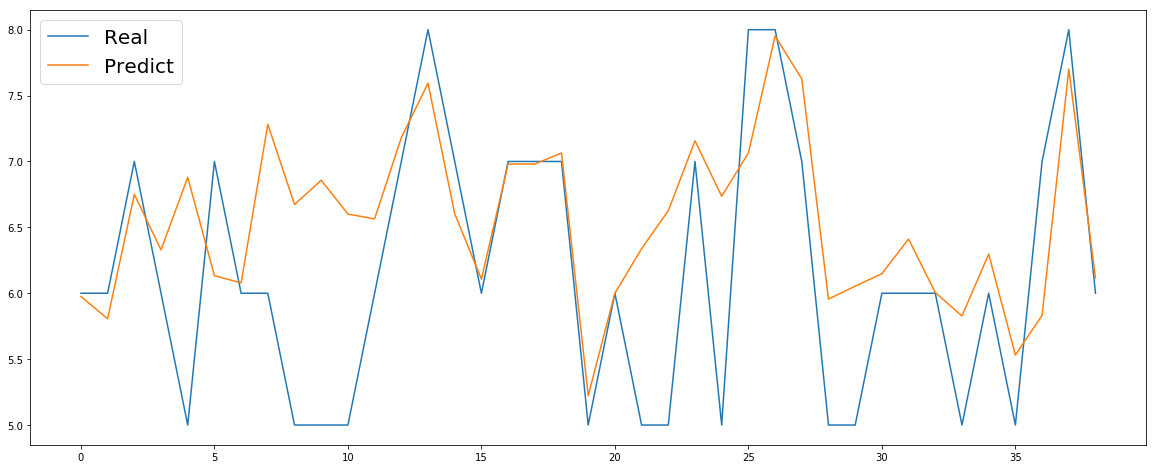

In [57]:

fig, ax = plt.subplots(figsize=(20, 8))

fig=pd.Series(scy.inverse_transform(yv)).plot(ax=ax, label="Real")
pd.Series(scy.inverse_transform(model.predict(Xv))).plot(ax=ax, label="Predict")


plt.legend(fontsize=20)

pickle.dump(model, open("Clientes 18%", "wb"))